# Model 2 - Simple fold

I want to create 3-4 simple models in order to show the effect of the distance algorithm for Kriging and how it can be applied to Gempy models. In general I think 3 Layers should be fine, cutting out the central one. Keeping all in the same size around max 5000 grid points gives reasonable calculation times.
1) flat horizontal 
2) anticline 
3) recumbent anticline
4) layer pinching out ?
5) should be something like a fault

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
import matplotlib 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import pandas as pd

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
geo_data = gp.create_data([0,1000,0,20,0,1000],resolution=[100,2,100], 
                        path_o = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model2_orientations_slice.csv", path_i = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model2_interfaces_slice.csv")


In [3]:
gp.set_series(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')},order_series = ['Strat_Series','Basement_Series'],
                       order_formations=np.array(['rock2','rock1','basement']), verbose=0)

In [4]:
colormodel = {'basement':'#ffa700','rock1':'#d62d20','rock2':'#0057e7','rock3':'#008744','fault':'#17202a'}
geo_data.set_colors(colormodel)
cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color']))
geo_data.formations

,value,formation_number,color
rock2,1,1,#0057e7
rock1,2,2,#d62d20
basement,3,3,#ffa700


In [5]:
#%matplotlib inline
#gp.get_sequential_pile(geo_data)

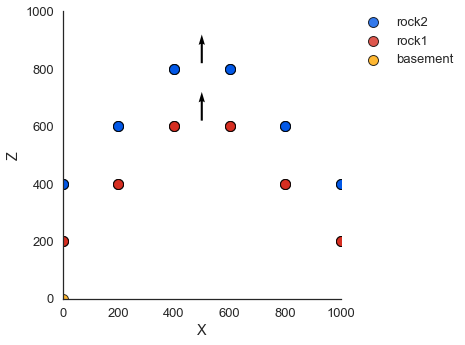

In [6]:
%matplotlib inline
gp.plotting.plot_data(geo_data, direction='y')

In [7]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...


INFO (theano.gof.compilelock): Waiting for existing lock by unknown process (I am process '9508')
INFO (theano.gof.compilelock): To manually release the lock, delete C:\Users\Jan\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.6.4-64\lock_dir
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [8]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


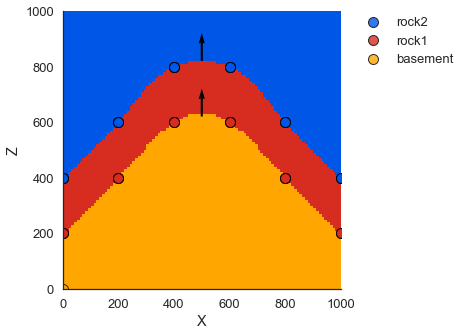

In [9]:
%matplotlib inline
gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=True, cmap=cmap, norm=None)

plt.savefig(fname='Model2_pure', edgecolor='black')

In [10]:
import gempy.utils.Kriging_Jan as krige

In [28]:
d = {'X': [500, 500], 'Y': [10, 10], 'Z': [750,750], 'Property': [20, 20]}
data_field = pd.DataFrame(data=d)
print(data_field)

     X   Y    Z  Property
0  500  10  750        20
1  500  10  750        20


In [29]:
np.random.seed(5023412)

In [36]:
test = krige.Kriging(data_field, lith_block, geo_data, formation_number=2, kriging_type='OK', distance_type='deformed_B', var_par=(200,50,1), an_factor=1)

initializing: 0.009798049926757812
Fault: False
10000
1
distance precalculation: 132.19037795066833
submatrix extraction: 0.0400233268737793
distance Matrices: 0.49508166313171387
kriging calculation: 0.8352241516113281
Negative Variances: 0
Out of: 4037


In [37]:
coord = test.result_coord[:3]
result = test.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

colormodel = {'basement':'#696969','rock1':'#A0A0A0','rock2':'#BEBEBE','rock3':'#008744','fault':'#17202a'}
geo_data.set_colors(colormodel)
cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color']))
#geo_data.formations

In [38]:
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

In [39]:
# work on fix to plot over basement
lith_block_aux = np.round(lith_block)
aux_where = np.where(lith_block_aux[0] == 3)
coord_aux = geo_data.grid.values
coord_aux_aux = coord_aux[aux_where]
print(coord_aux_aux.shape)
coord_aux_aux[:,0]

(8904, 3)


array([  5.,   5.,   5., ..., 995., 995., 995.], dtype=float32)

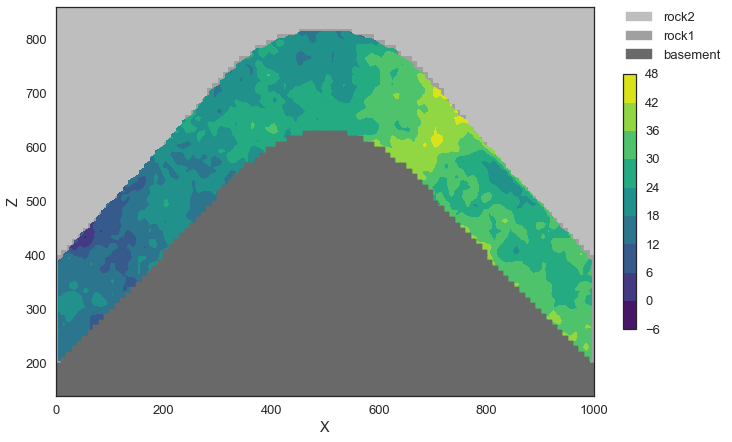

In [40]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

#norm=matplotlib.colors.Normalize(vmin=0, vmax=40)
#v = np.linspace(0, 40,11, endpoint=True)

b = plt.scatter(x=coord_aux_aux[:,0], y=coord_aux_aux[:,2], c='#696969', s=27, marker=',',zorder=2)

a = plt.contourf(X, Y, Z, cmap='viridis', zorder=1)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

c = plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)


plt.savefig(fname='Fold_200_50_1_an=5_b', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()

(200, 800)

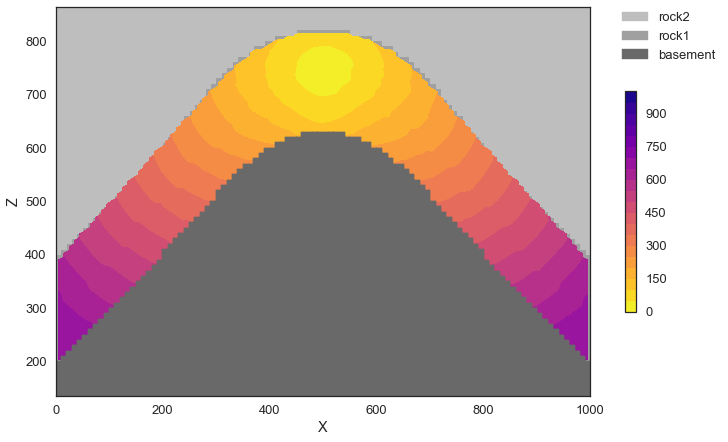

In [41]:
coord_dist = test.result_coord[:3]
dist_plt = test.dist_matrix_plt[:,1]
combined = np.vstack((coord_dist, dist_plt))
combined = np.swapaxes(combined,0,1)
combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

b = plt.scatter(x=coord_aux_aux[:,0], y=coord_aux_aux[:,2], c='#696969', s=27, marker=',',zorder=2)

X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=0, vmax=1000)
v = np.linspace(0, 1000,21, endpoint=True)

a = plt.contourf(X, Y, Z, v, cmap='plasma_r', norm=norm)
b = plt.contourf(X, Y, Z, v, cmap='plasma_r', norm=norm)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.colorbar(a, orientation='vertical', fraction=0.019, pad=0.06)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

#plt.savefig(fname='Distance_Fault_200_50_1_an=1_B_off462', edgecolor='black')